## POOL WETH_USDC
**Characteristics: High capitalization, relatively high transaction frequency**
### Comparison simulation - volatility mitigator disabled/enabled

*VM parameters (custom):* 
- WINDOW_SIZE = 24h
- PERIOD_SIZE = 1h
- PRICE_TOLLERANCE_TRESHOLD = 98

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 1000)

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [3]:
EXPERIMENT_ID = 57

X_NAME = 'WETH'
Y_NAME = 'USDC'

WINDOW_SIZE = 24 * 60 * 60

In [4]:
BASE_DIR = fr'..\..\..\data\real_transactions\experiment_{EXPERIMENT_ID}'

In [5]:
os.listdir(BASE_DIR)

['0', '1', 'config.txt']

In [6]:
def read_simulation(sim_id: int):
    pool_state_before_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_before_transaction_normalized.csv'
    pool_state_after_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_after_transaction_normalized.csv'
    swap_transactions_path = fr'{BASE_DIR}\\{sim_id}\swaps_normalized.csv'
    mint_transactions_path = fr'{BASE_DIR}\\{sim_id}\mints_normalized.csv'
    burn_transactions_path = fr'{BASE_DIR}\\{sim_id}\burns_normalized.csv'
    
    # read swaps
    pool0_df = pd.read_csv(pool_state_before_transactions_path)
    pool1_df = pd.read_csv(pool_state_after_transactions_path)
    swaps_df = pd.read_csv(swap_transactions_path)
    
    pool0_df.columns = pool0_df.columns.map(lambda x : x + '_before' if x != 'transaction_id' else x)

    swaps_df = pd.merge(swaps_df, pool0_df, left_on='id', right_on='transaction_id')
    swaps_df = pd.merge(swaps_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    swaps_df['transaction_timestamp'] = pd.to_datetime(swaps_df.transaction_timestamp, unit='s')
    swaps_df['block_timestamp'] = pd.to_datetime(swaps_df.block_timestamp, unit='s')
    
    swaps_df.loc[:, 'X_price'] = swaps_df['reserve_Y'] / swaps_df['reserve_X']
    
    # price impact of swap / 100%
    swaps_df.loc[:, 'price_diff'] = (swaps_df['reserve_Y'] / swaps_df['reserve_X'] - swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before']) / (swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before'])
    
    # read mints
    mints_df = pd.read_csv(mint_transactions_path)
    mints_df = pd.merge(mints_df, pool0_df, left_on='id', right_on='transaction_id')
    mints_df = pd.merge(mints_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    # read burns
    burns_df = pd.read_csv(burn_transactions_path)
    burns_df = pd.merge(burns_df, pool0_df, left_on='id', right_on='transaction_id')
    burns_df = pd.merge(burns_df, pool1_df, left_on='transaction_id', right_on='transaction_id') 
    
    return swaps_df, mints_df, burns_df

In [7]:
swaps0_df, mints0_df, burns0_df = read_simulation(0) # without vm
swaps1_df, mints1_df, burns1_df = read_simulation(1) # with vm

In [8]:
swaps0_df.head()

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,1,WETH,USDC,0.000005,0.0,0.000993,0.000004,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,10,2020-05-05 21:09:42,2020-05-05 21:09:32,0x932cb88306450d481a0e43365a3ed832625b68f036e9...,1,0.004854,1.000000,0.004854,0,0,False,0.004859,0.999003,0.004854,0,0,False,205.588213,-0.001999
1,2,WETH,USDC,0.000049,0.0,0.009931,0.000040,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,22,2020-05-05 21:12:42,2020-05-05 21:12:35,0x697b7aaca56a80a8d3a2f560ed7f1ecb97c22b2edd6e...,2,0.004859,0.999003,0.004854,0,0,False,0.004909,0.989033,0.004855,37005,0,False,201.492934,-0.019920
2,3,WETH,USDC,0.000005,0.0,0.000993,0.000004,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,4631,2020-05-06 16:24:57,2020-05-06 16:24:55,0x43b6bfd06dde0814fe9c1b63ce98ec4c67c72d96169d...,3,0.004909,0.989033,0.004855,37005,0,False,0.004914,0.988036,0.004855,13967219,343,False,201.085679,-0.002021
3,4,USDC,WETH,0.000689,0.0,0.000003,0.000003,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,5216,2020-05-06 18:51:12,2020-05-06 18:51:12,0x735cf98e86a5df67b6a837ae50de1d7a589d9f6baaf0...,4,0.004914,0.988036,0.004855,13967219,343,False,0.004910,0.988722,0.004855,15731746,387,False,201.364264,0.001385
4,12,WETH,USDC,0.001000,0.0,0.203478,0.000814,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,32647,2020-05-11 13:08:57,2020-05-11 13:08:48,0x840bb5ab0a779b4f733443651ac54dabe24e243c3606...,12,0.030998,6.574504,0.203794,15731746,387,False,0.031998,6.370212,0.203831,103002459,2327,False,199.084373,-0.061355


In [9]:
swaps0_df.status.value_counts()

SUCCESS    2895926
Name: status, dtype: int64

In [10]:
swaps1_df.status.value_counts()

SUCCESS                             2895924
BLOCKED_BY_VOLATILITY_MITIGATION          2
Name: status, dtype: int64

In [11]:
ratio_blocked_volatility = swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION'].shape[0]/swaps1_df.shape[0] 

print(f"Blocked by volatility mitigator ratio: {ratio_blocked_volatility}")

Blocked by volatility mitigator ratio: 6.906253820021644e-07


In [12]:
swaps1_df.mitigator_check_status.value_counts()

CHECKED                2895683
CANT_CONSULT_ORACLE        243
Name: mitigator_check_status, dtype: int64

In [13]:
ratio_twap_not_available = swaps1_df[swaps1_df.mitigator_check_status == 'CANT_CONSULT_ORACLE'].shape[0]/swaps1_df.shape[0] 

print(f"TWAP not available ratio: {ratio_twap_not_available}")

TWAP not available ratio: 8.391098391326297e-05


In [14]:
# Check if all burns were completed successfully

print("Burns status without volatility mitigation mechanism")
print(burns0_df.status.value_counts())

print("\nBurns status with volatility mitigation mechanism")
print(burns0_df.status.value_counts())

Burns status without volatility mitigation mechanism
SUCCESS    23361
Name: status, dtype: int64

Burns status with volatility mitigation mechanism
SUCCESS    23361
Name: status, dtype: int64


**Only 2 out of 2 895 926** have been **blocked by the volatility mitigation mechanism**. Only in 243 of the cases there were missing TWAP observations, all of which were at the beginning of the pool creation.

### Table of transactions blocked by Volatility Mitigation Mechanism

In [17]:
# swap transactions blocked by volatility mitigator mechanism
swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION'][['token_in', 'token_out', 'token_in_amount', 'token_out_amount', 'slice_factor', 'out_amount_diff', 'reserve_Y_before', 'reserve_Y_before', 'transaction_timestamp']]

,token_in,token_out,token_in_amount,token_out_amount,slice_factor,out_amount_diff,reserve_Y_before,reserve_Y_before,transaction_timestamp
15,USDC,WETH,3.5,0.018075,20.0,86.0,1.780154e+01,1.780154e+01,2020-05-13 22:25:22
17519,USDC,WETH,296400.0,1024.751691,21.0,19.0,1.460402e+06,1.460402e+06,2020-06-23 02:42:56


Note that the blocked transactions seem to be MEV bot sandwih attacks, as they have happened 2 by 2 at the same timestamp

**The blocked transactions have a  price difference with the one from oracle greater than 19%**

Text(0.5, 1.0, 'Swaps slice_factor/out_amount_diff scatterplot (split by status)')

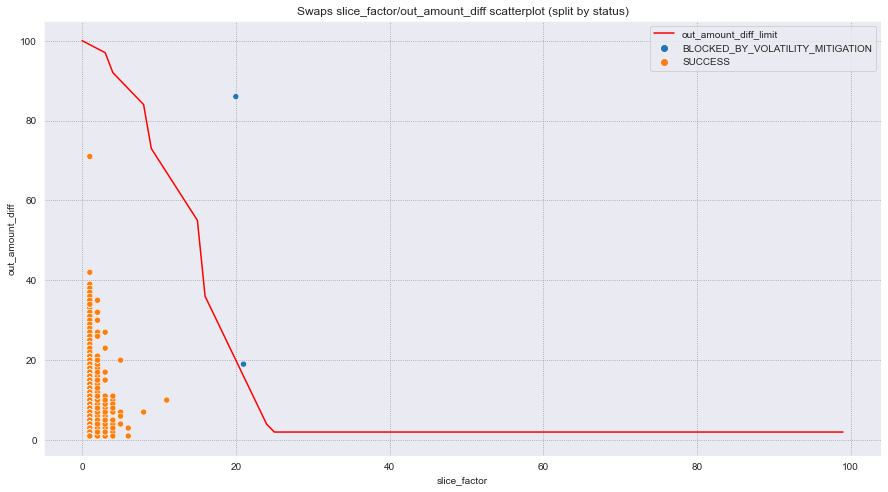

In [118]:
from scipy import stats

fig, ax = plt.subplots(figsize=(15, 8))
    
sns.scatterplot(data=swaps1_df[swaps1_df.mitigator_check_status == 'CHECKED'], x='slice_factor', y='out_amount_diff', hue='status')

slice_factor = np.arange(0, 100)
slice_factor_curve = slice_factor * np.sqrt(slice_factor).astype(int)
slice_factor_curve[slice_factor_curve > 98] = 98
out_amount_diff = (100 - slice_factor_curve)
sns.lineplot(x=slice_factor, y=out_amount_diff, color='red', label='out_amount_diff_limit')
ax.set_title('Swaps slice_factor/out_amount_diff scatterplot (split by status)')

The out_amount_diff_limit border is not smooth, because the slice_factor_curve is computed according to the formula slice_factor * sqrt(slice_factor), where the sqrt(slice_factor) is rounded down in the original contract

Overall, the border seems to separete the successful and blocked transactions pretty good, and the slice_factor_curve formula doesn't seem to require additional adjustments. 

Text(0, 0.5, 'Count')

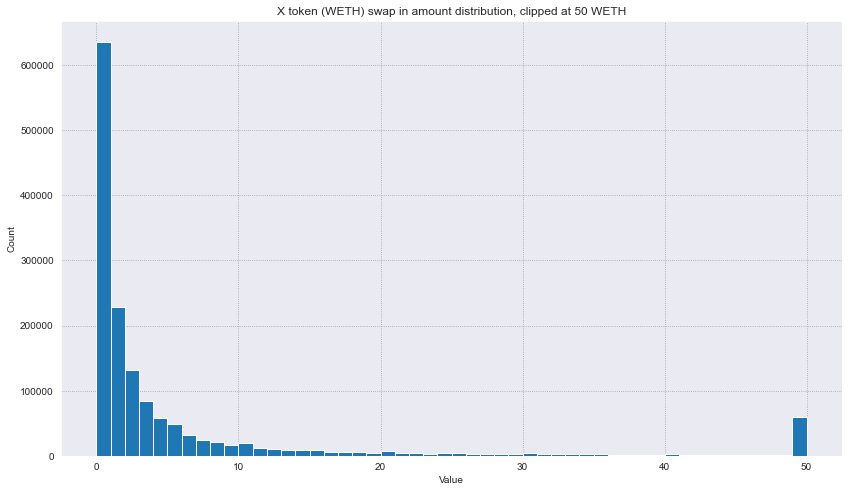

In [119]:
UPPER_LIMIT = 50

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == X_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"X token ({X_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {X_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

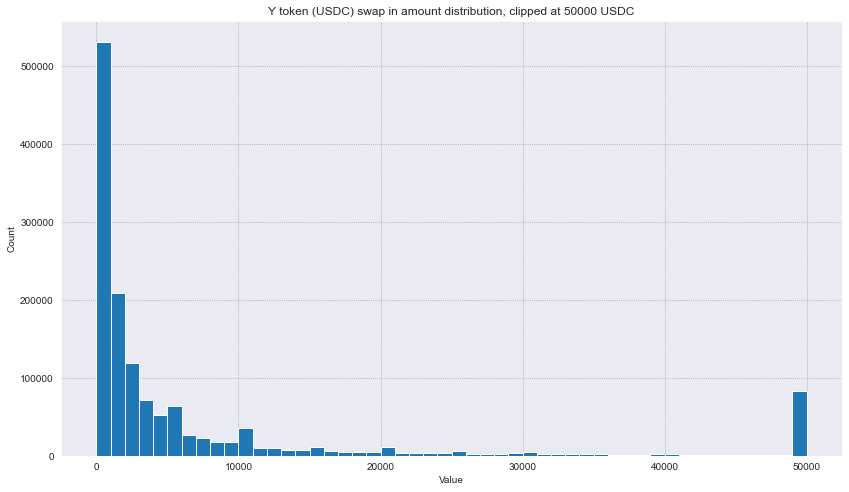

In [120]:
UPPER_LIMIT = 50000

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {Y_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

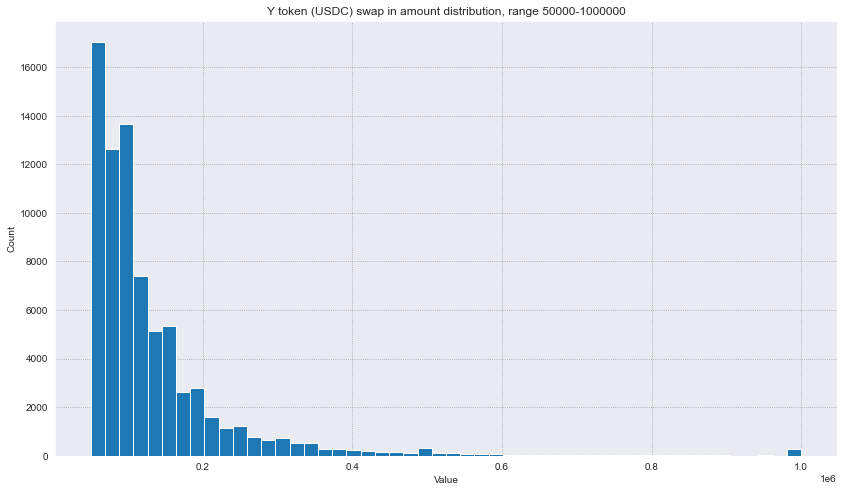

In [121]:
LOWER_LIMIT = 50000
UPPER_LIMIT = 1000000
fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT
amounts = amounts[amounts > LOWER_LIMIT]
ax = amounts.hist(range=(LOWER_LIMIT, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, range {LOWER_LIMIT}-{UPPER_LIMIT}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

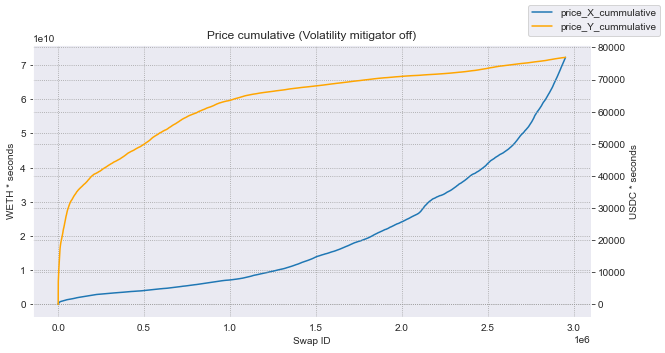

In [122]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.id, swaps0_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps1_df.id, swaps1_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator off)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

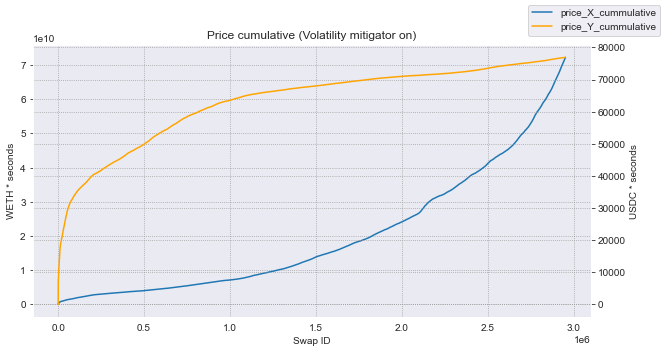

In [123]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.id, swaps1_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps1_df.id, swaps1_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator on)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

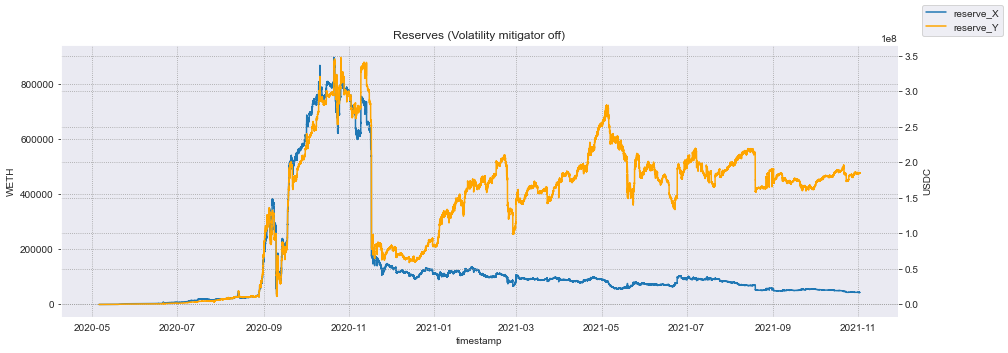

In [124]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_X, label='reserve_X')
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator off)')

fig.legend()

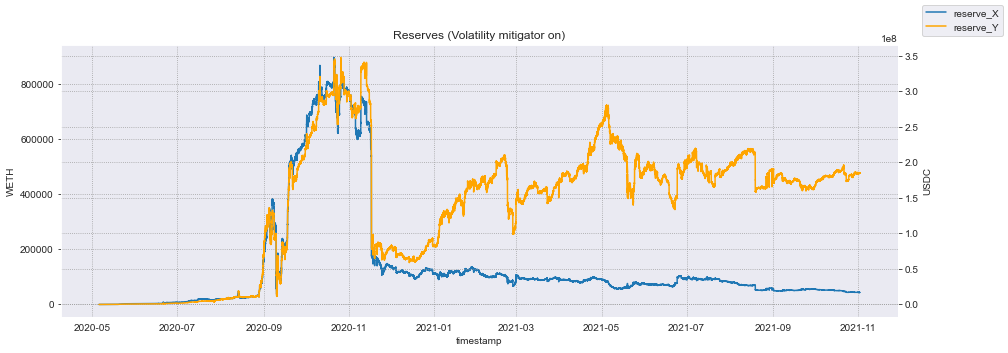

In [125]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_X, label='reserve_X')
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator on)')

fig.legend()

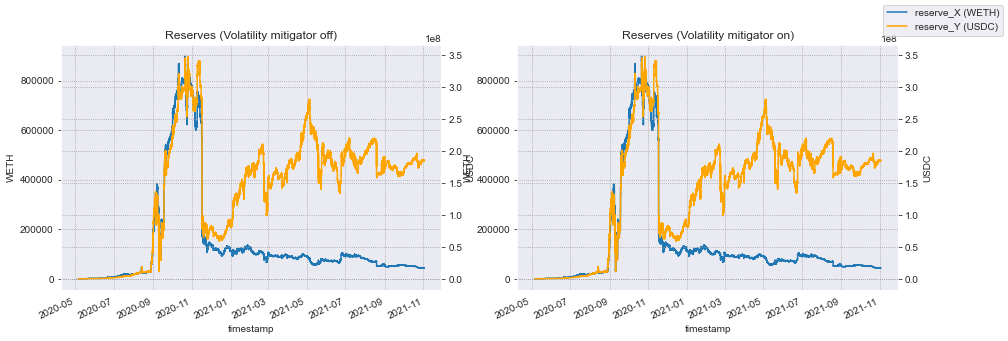

In [18]:

fig, ax = plt.subplots(1, 2,figsize=(15, 5))

ax2 = ax[0].twinx()

ax[0].plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_X, label=f'reserve_X ({X_NAME})')
ax2.plot(swaps0_df.transaction_timestamp, swaps1_df.reserve_Y, label=f'reserve_Y ({Y_NAME})', color='orange')

ax[0].set_xlabel('timestamp')
ax[0].set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax[0].set_title('Reserves (Volatility mitigator off)')

ax2 = ax[1].twinx()


ax[1].plot(swaps1_df.transaction_timestamp, swaps0_df.reserve_X, )
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, color='orange')

ax[1].set_xlabel('timestamp')
ax[1].set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax[1].set_title('Reserves (Volatility mitigator on)')

fig.autofmt_xdate(rotation=25)

fig.legend()

In [126]:
swaps0_df

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,1,WETH,USDC,0.000005,0.0,0.000993,0.000004,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,10,2020-05-05 21:09:42,2020-05-05 21:09:32,0x932cb88306450d481a0e43365a3ed832625b68f036e9...,1,0.004854,1.000000e+00,4.854369e-03,0,0,False,0.004859,9.990030e-01,4.854398e-03,0,0,False,205.588213,-0.001999
1,2,WETH,USDC,0.000049,0.0,0.009931,0.000040,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,22,2020-05-05 21:12:42,2020-05-05 21:12:35,0x697b7aaca56a80a8d3a2f560ed7f1ecb97c22b2edd6e...,2,0.004859,9.990030e-01,4.854398e-03,0,0,False,0.004909,9.890328e-01,4.854691e-03,37005,0,False,201.492934,-0.019920
2,3,WETH,USDC,0.000005,0.0,0.000993,0.000004,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,4631,2020-05-06 16:24:57,2020-05-06 16:24:55,0x43b6bfd06dde0814fe9c1b63ce98ec4c67c72d96169d...,3,0.004909,9.890328e-01,4.854691e-03,37005,0,False,0.004914,9.880358e-01,4.854720e-03,13967219,343,False,201.085679,-0.002021
3,4,USDC,WETH,0.000689,0.0,0.000003,0.000003,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,5216,2020-05-06 18:51:12,2020-05-06 18:51:12,0x735cf98e86a5df67b6a837ae50de1d7a589d9f6baaf0...,4,0.004914,9.880358e-01,4.854720e-03,13967219,343,False,0.004910,9.887221e-01,4.854741e-03,15731746,387,False,201.364264,0.001385
4,12,WETH,USDC,0.001000,0.0,0.203478,0.000814,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,32647,2020-05-11 13:08:57,2020-05-11 13:08:48,0x840bb5ab0a779b4f733443651ac54dabe24e243c3606...,12,0.030998,6.574504e+00,2.037935e-01,15731746,387,False,0.031998,6.370212e+00,2.038312e-01,103002459,2327,False,199.084373,-0.061355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895921,2952010,WETH,USDC,11.552050,0.0,48446.909341,193.787637,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,3140600,2021-11-02 02:57:12,2021-11-02 02:57:02,0x1c5a9c558a8d3959c4cebf3cd52df35a03a41b8f19b4...,2952010,43712.243000,1.852203e+08,8.096394e+12,72258179798,76531,False,43723.795050,1.851716e+08,8.096406e+12,72258306916,76531,False,4235.031105,-0.000527
2895922,2952011,USDC,WETH,1000.000000,0.0,0.233763,4.000000,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,3140602,2021-11-02 02:57:42,2021-11-02 02:57:31,0x0262ea4a7b11af147b694e692fd5dbfb812b445b4e71...,2952011,43723.795050,1.851716e+08,8.096406e+12,72258306916,76531,False,43723.561287,1.851726e+08,8.096407e+12,72258433967,76531,False,4235.076526,0.000011
2895923,2952012,USDC,WETH,3000.000000,0.0,0.701275,12.000000,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,3140605,2021-11-02 02:58:27,2021-11-02 02:58:25,0x8316bfabdab5fb94ed1960bbfe4cd40eaafc78c94c9e...,2952012,43723.561287,1.851726e+08,8.096407e+12,72258433967,76531,False,43722.860012,1.851756e+08,8.096408e+12,72258624546,76531,False,4235.212793,0.000032
2895924,2952013,WETH,USDC,1.486875,0.0,6234.049821,24.936199,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,3140606,2021-11-02 02:58:42,2021-11-02 02:58:34,0x16908278f6eb318d808662f2540ece2977e075461ba8...,2952013,43722.860012,1.851756e+08,8.096408e+12,72258624546,76531,False,43724.346887,1.851694e+08,8.096409e+12,72258688074,76531,False,4234.925625,-0.000068


**The variation of reserves over time is very similar at the first glance with and without the volatility mitigator**

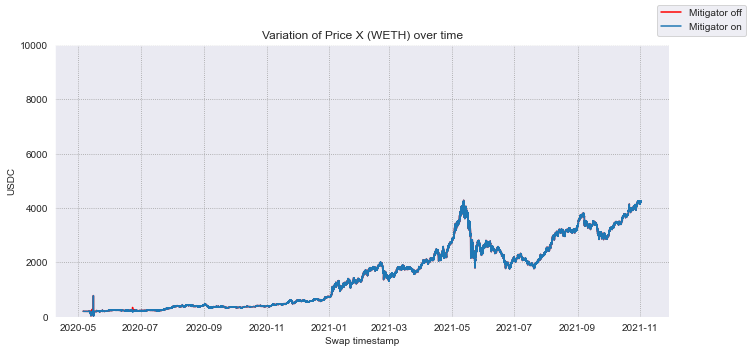

In [20]:
fig, ax = plt.subplots(figsize=(11, 5))

ax.plot_date(x=swaps0_df['transaction_timestamp'], y=swaps0_df['X_price'], linestyle='solid', marker=None, label='Mitigator off', color='red')
ax.plot_date(x=swaps1_df['transaction_timestamp'], y=swaps1_df['X_price'], linestyle='solid', marker=None, label='Mitigator on',)

ax.set_title(f'Variation of Price X ({X_NAME}) over time')
ax.set_ylim(0, 10000)
ax.set_xlabel('Swap timestamp')
ax.set_ylabel(Y_NAME)
fig.legend()

**The price is almost identical in both simulation modes. There can be seen some deviations in the beginning since pool creation**

## Count number of 1 hour periods with no swaps

Below, the distribution of the number of swaps per hour, for 3 stages of the same duration of the pool is computed 

- 1st stage - initial period 
- 2nd stage - middle period
- 3nd stage - last period

In [132]:
sim1_indexed_df = swaps1_df.copy()
sim1_indexed_df.index = swaps1_df.transaction_timestamp
resampled = sim1_indexed_df.resample('1h').size()
resampled

transaction_timestamp
2020-05-05 21:00:00      2
2020-05-05 22:00:00      0
2020-05-05 23:00:00      0
2020-05-06 00:00:00      0
2020-05-06 01:00:00      0
                      ... 
2021-11-01 22:00:00    117
2021-11-01 23:00:00    112
2021-11-02 00:00:00    130
2021-11-02 01:00:00     69
2021-11-02 02:00:00     98
Freq: H, Length: 13086, dtype: int64

In [133]:
resampled[resampled == 0]

transaction_timestamp
2020-05-05 22:00:00    0
2020-05-05 23:00:00    0
2020-05-06 00:00:00    0
2020-05-06 01:00:00    0
2020-05-06 02:00:00    0
2020-05-06 03:00:00    0
2020-05-06 04:00:00    0
2020-05-06 05:00:00    0
2020-05-06 06:00:00    0
2020-05-06 07:00:00    0
2020-05-06 08:00:00    0
2020-05-06 09:00:00    0
2020-05-06 10:00:00    0
2020-05-06 11:00:00    0
2020-05-06 12:00:00    0
2020-05-06 13:00:00    0
2020-05-06 14:00:00    0
2020-05-06 15:00:00    0
2020-05-06 17:00:00    0
2020-05-06 19:00:00    0
2020-05-06 20:00:00    0
2020-05-06 21:00:00    0
2020-05-06 22:00:00    0
2020-05-06 23:00:00    0
2020-05-07 00:00:00    0
2020-05-07 01:00:00    0
2020-05-07 02:00:00    0
2020-05-07 03:00:00    0
2020-05-07 04:00:00    0
2020-05-07 05:00:00    0
2020-05-07 06:00:00    0
2020-05-07 07:00:00    0
2020-05-07 08:00:00    0
2020-05-07 09:00:00    0
2020-05-07 10:00:00    0
2020-05-07 11:00:00    0
2020-05-07 12:00:00    0
2020-05-07 13:00:00    0
2020-05-07 14:00:00    0
202

It can be seen that the only periods with no transaction happening during an entire hour are in May 2020, at the creation of the pool

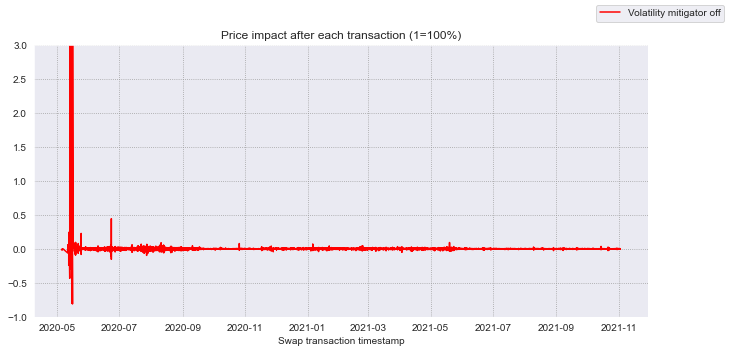

In [21]:
fig, ax = plt.subplots(figsize=(11, 5))

ax.plot_date(data=swaps0_df, x='transaction_timestamp', y='price_diff', linestyle='solid', color='red', marker=None, label='Volatility mitigator off')
#ax.plot_date(data=swaps1_df, x='transaction_timestamp', y='price_diff', linestyle='solid', marker=None, label='Volatility mitigator on')

ax.set_ylim(-1, 3)
ax.set_xlabel('Swap transaction timestamp')
ax.set_title('Price impact after each transaction (1=100%)')
fig.legend()

It can be noticed that the price impact of each transaction is extremely small. There are almost no MEV-bot sandwich attacks in this pool, as it would require a very high amount of tokens, because of the big reserves amount

As there are no periods of no swaps happening during an hour period (after 1 month since pool creation), in can be concluded hat with applied modification the simulation results should be the same (except for the first month)